In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from bs4 import BeautifulSoup

In [2]:
def get_player_stats(player_url, player_name):
    response = requests.get(player_url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(response.text, "html.parser")
    stats = {}
    tables = soup.find_all('table')
    for table in tables:
        caption = table.find("caption")
        header = table.find("th", colspan="2")

        title = ""
        if caption and caption.get_text(strip=True):
            title = caption.get_text(strip=True)
        elif header and header.get_text(strip=True):
            title = header.get_text(strip=True)

        rows = table.find_all("tr")
        for row in rows:
            cols = row.find_all("td")
            if len(cols) == 2:
                label = cols[0].get_text(" ", strip=True).replace(":", "")
                value = cols[1].get_text(" ", strip=True)
                if label or value:
                    stats[f"{player_name} {title} - {label}"] = value
    return stats

In [3]:
def process_stat_value(value):
    if pd.isna(value) or value == '' or value == '-':
        return None
    try:
        str_value = str(value).strip().replace('%', '').replace(',', '').replace('$', '')
        return float(str_value) if str_value else None
    except (ValueError, TypeError):
        return None

In [4]:
def display_comparison_table(comparison_df):
    comparison_df = comparison_df.fillna(0)
    print("\n" + "=" * 80)
    print("\U0001F3C6 MID LANER COMPARISION")
    print("=" * 80)
    print(comparison_df.to_string(float_format='%.2f'))

    print("\n\U0001F4CA PERFORMANCE OVERVIEW:")
    print("-" * 50)
    numeric_df = comparison_df.select_dtypes(include=['float64', 'int64'])
    if not numeric_df.empty:
        for column in numeric_df.columns:
            valid_data = numeric_df[column].dropna()
            if len(valid_data) > 0:
                best_player = valid_data.idxmax()
                best_value = valid_data.max()
                print(f"🥇 {column}: {best_player} ({best_value:.3f})")

        print("💥💥💥 CHOVY DOMINATES EVERY TOP OPPONENT. WHEN CONSISTENCY MEETS MECHANICAL PERFECTION, YOU GET THE BEST MID LANER IN THE WORLD👑👑👑")
    print("=" * 80)

In [5]:
def normalize_series(series: pd.Series) -> pd.Series:
    max_val = series.max()
    if max_val == 0:
        return pd.Series(0.0, index=series.index)
    normalized = series / max_val
    normalized = normalized.apply(lambda x: max(x, 0.05))
    return normalized

def plot_radar_chart(df: pd.DataFrame, player_name: str, color:str = 'blue'):
    # 1. Lọc chỉ số dạng số, NaN = 0
    metrics = df.select_dtypes(include=[np.number]).copy().fillna(0)


    # 2. Normalize
    metrics = metrics.apply(normalize_series)

    if player_name not in metrics.index:
        raise ValueError(f"Tuyển thủ '{player_name}' không tồn tại trong dữ liệu.")

    # 3. Trích dữ liệu
    data = metrics.loc[player_name]
    labels = data.index.tolist()
    values = data.values

    # 4. Khép kín đa giác
    values = np.concatenate([values, [values[0]]])
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1)

    # 5. Vẽ
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
    ax.plot(angles, values, '-o', linewidth=2,color = 'black',markerfacecolor='black',markeredgecolor='black', label=player_name)
    ax.fill(angles, values, alpha=0.25,color = color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_yticklabels([])
    ax.set_title(f"Radar Chart: {player_name}", pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def create_rader_charts(df: pd.DataFrame):
    players = {
        "Shanks": "black",
        "Knight": "cyan",
        "Zeka": "orange",
        "Faker": "red",
        "Chovy": "yellow"
    }
    for name, color in players.items():
        plot_radar_chart(df,name,color=color)
    print("\n NOT EVEN CLOSE ☠️☠️☠️")
    print("\n STATS DON'T LIE. CHOVY IS HIM.🔥🔥🔥")


In [ ]:
def main():
    players = {
        "Chovy": "https://gol.gg/players/player-stats/1629/season-ALL/split-ALL/tournament-LCK%202025%20Rounds%201-2/",
        "Faker": "https://gol.gg/players/player-stats/48/season-ALL/split-ALL/tournament-LCK%202025%20Rounds%201-2/",
        "Shanks": "https://gol.gg/players/player-stats/3344/season-ALL/split-ALL/tournament-LPL%202025%20Split%202/",
        "Zeka": "https://gol.gg/players/player-stats/2906/season-ALL/split-ALL/tournament-LCK%202025%20Rounds%201-2/",
        "Knight": "https://gol.gg/players/player-stats/1270/season-ALL/split-ALL/tournament-LPL%202025%20Split%202/"
    }

    metrics = {
        "KDA": "KDA",
        "CS per Minute": "CS per Minute",
        "Solo kills": "Solo kills",
        "Damage Per Minute": "Damage Per Minute",
        "Gold Per Minute": "Gold Per Minute",
        "Kill Participation": "Kill Participation",
        "Gold%": "Gold%",
        "CS Differential at 15 min": "CS Differential at 15 min",
        "Gold Differential at 15 min": "Gold Differential at 15 min",
        "First Blood Participation": "First Blood Participation",
        "K+A Per Minute": "K+A Per Minute",
        "Pentakills": "Pentakills",
    }

    stats = {}
    print("\U0001F680 Starting data collection...")
    print("=" * 60)
    for i, (player, url) in enumerate(players.items(), 1):
        print(f"[{i}/{len(players)}] \U0001F4CA Loading {player} stats...")
        player_stats = get_player_stats(url, player)
        if player_stats:
            stats[player] = player_stats
            print(f"   ✅ Success! ({len(player_stats)} metrics)")
        else:
            print(f"   ❌ Failed!")
    print("=" * 60)
    print(f"\U0001F389 Completed! Collected data for {len(stats)} players")

    comparison_data = {}
    missing_metrics = []
    print("\n\U0001F50D Processing comparison data...")
    for player in players:
        if player not in stats:
            print(f"   ⚠️  No data available for {player}")
            continue
        player_stats = {}
        for metric_name, partial_key in metrics.items():
            matched = [v for k, v in stats[player].items() if partial_key in k]
            if matched:
                processed_value = process_stat_value(matched[0])
                player_stats[metric_name] = processed_value
            else:
                missing_metrics.append(f"{player} - {partial_key}")
                player_stats[metric_name] = None
        comparison_data[player] = player_stats

    if missing_metrics:
        print(f"   ⚠️  Missing {len(missing_metrics)} metrics:")
        for missing in missing_metrics[:5]:
            print(f"      • {missing}")
        if len(missing_metrics) > 5:
            print(f"      • ... and {len(missing_metrics) - 5} more metrics")

    df = pd.DataFrame.from_dict(comparison_data, orient="index")
    df = df.fillna(0)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = df[numeric_columns].round(3)

    display_comparison_table(df)
    print("\n\U0001F4CA Creating visualizations...")
    # Vẽ tất cả tuyển thủ
    create_rader_charts(df)


🚀 Starting data collection...
[1/5] 📊 Loading Chovy stats...
   ✅ Success! (26 metrics)
[2/5] 📊 Loading Faker stats...
   ✅ Success! (26 metrics)
[3/5] 📊 Loading Shanks stats...
   ✅ Success! (27 metrics)
[4/5] 📊 Loading Zeka stats...
   ✅ Success! (26 metrics)
[5/5] 📊 Loading Knight stats...
   ✅ Success! (27 metrics)
🎉 Completed! Collected data for 5 players

🔍 Processing comparison data...

🏆 MID LANER COMPARISION
        KDA  CS per Minute  Solo kills  Damage Per Minute  Gold Per Minute  Kill Participation  Gold%  CS Differential at 15 min  Gold Differential at 15 min  First Blood Participation  K+A Per Minute  Pentakills
Chovy  7.30           9.70        9.00             795.50           454.00               67.30  22.60                       8.60                       380.00                      24.40            0.39        1.00
Faker  4.40           8.70        6.00             708.40           407.00               62.70  21.50                       0.50                       -4

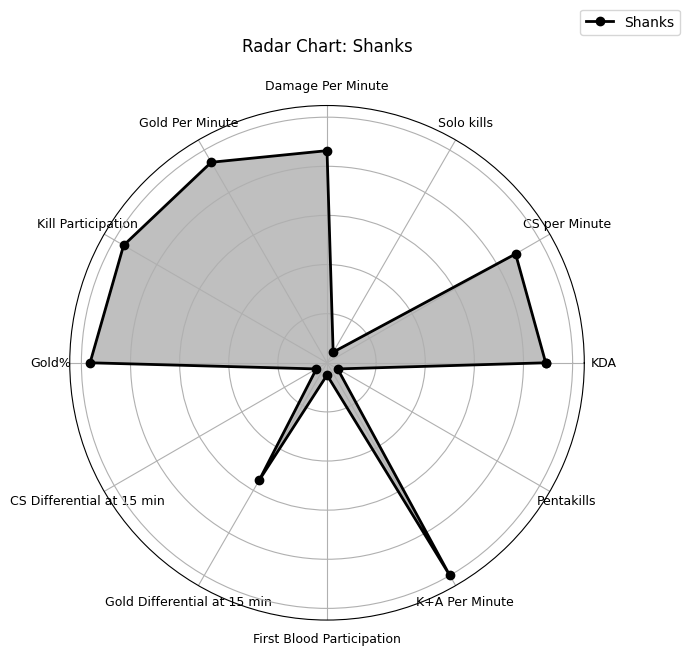

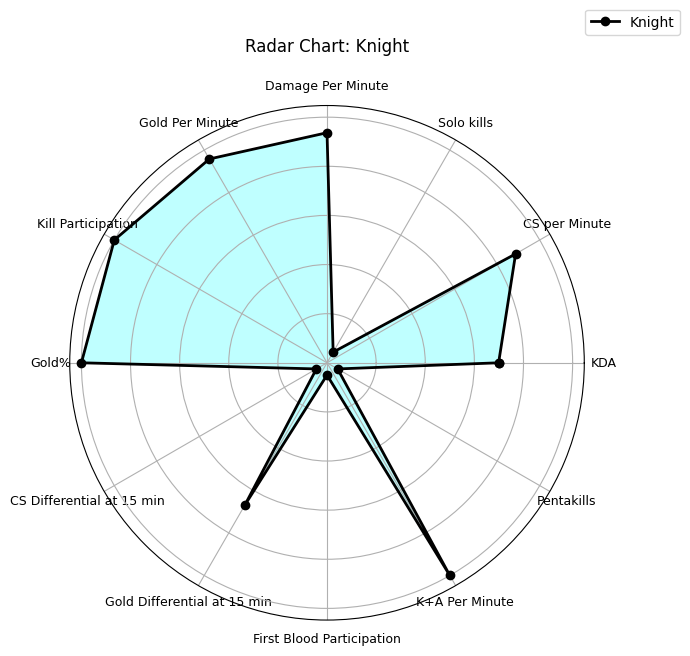

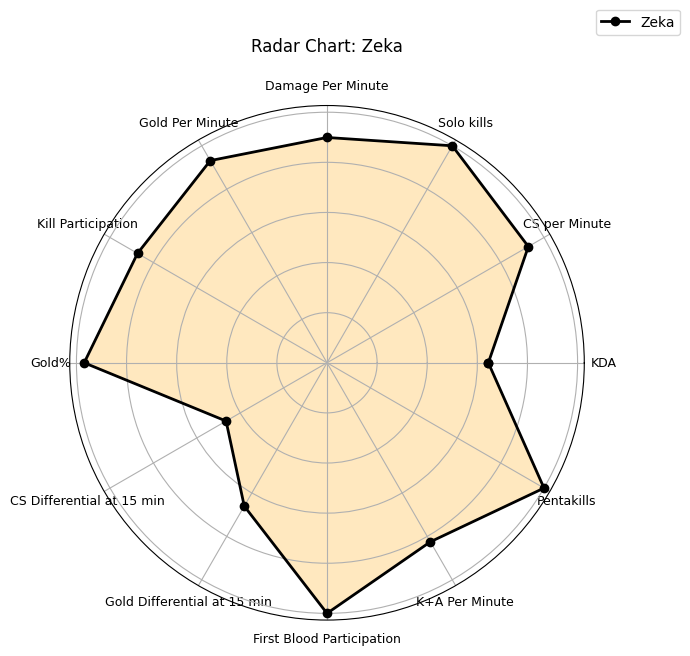

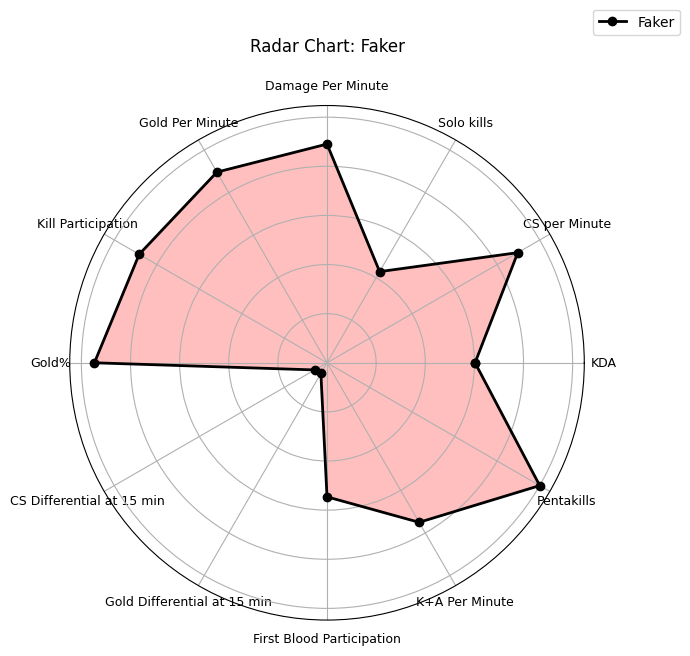

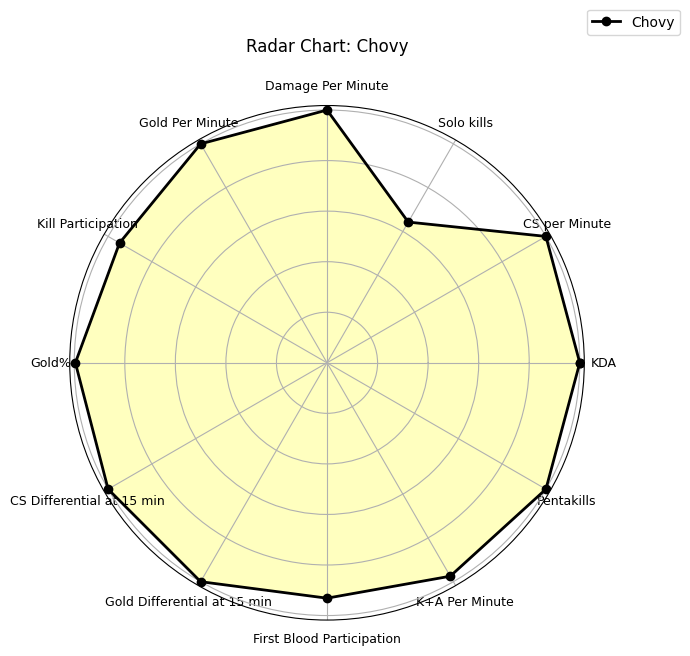


 NOT EVEN CLOSE ☠️☠️☠️

 STATS DON'T LIE. CHOVY IS HIM.🔥🔥🔥


In [7]:
main()